## CS82 data

###CFHT Stripe 82 survey catalogs:###

- Clusters: identified with RedMaPPer (1502 clusters with $\lambda \gt 15$)
- Sources: detection with SExtractor, lensing with Lensfit, photo-z with EAZY

###Clusters selection:###

- Using cluster with P_CEN>0.9 for the BCG: 843 clusters (to minimize the miscentering problem)  

- Separating in redshift and richness bins:
  - 0.2 < z < 0.4 and 20 < λ < 30 = 57
  - 0.2 < z < 0.4 and 30 < λ < 200 = 31
  - 0.4 < z < 0.6 and 20 < λ < 30 = 96
  - 0.4 < z < 0.6 and 30 < λ < 200 =75

###Sources selection:###

- Simple cuts in FLAGS, CLASS_STAR, etc: 4.449.977

###Stacking of clusters:###

- Using xshear code to measure the shear components around each lens. Measure the tangential shear in radial rings around the position of BCG (position for the highest probability BCG). Return average quantities rsum, dsum, osum, etc.
    
- Stacking the signal: a sum of the signal in each bin i and then average them:  

    r = rsum_i/wsum_i
    
    \Delta\Sigma_+^i = dsum_i/wsum_i
    
    \Delta\Sigma_x^i = osum_i/wsum_i
    
    
- Errors: bootstrap, but I'm not sure about them yet.

- Result: ascii file with average $R$, $\Delta\Sigma$ and $\Delta\Sigma_{error}$ 


## Read in some Data

We'll just work with one dataset, and try and infer some parameters and their uncertainties.

In [245]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0) 

In [246]:
d=np.loadtxt('maria_wlprofiles/sigma_cluster_z0204')

In [247]:
# Check this data array:
print(d)

[[  1.43107900e-01   1.52025000e+02   8.58345600e+01]
 [  2.54487000e-01   8.30496700e+01   4.93088000e+01]
 [  4.52548800e-01   6.29833300e+01   2.89130600e+01]
 [  8.04760200e-01   3.32727000e+01   1.72114200e+01]
 [  1.43108600e+00   2.21218800e+01   1.02587500e+01]
 [  2.54487200e+00   8.67255000e+00   5.91305400e+00]
 [  4.52549500e+00   1.47755600e+00   3.38065100e+00]
 [  8.04759300e+00   3.47595500e+00   1.99723600e+00]]


In [268]:
R,DSobs,DSerr = d[:,0],d[:,1],d[:,2]

In [277]:
print(R, DSobs, DSerr)

[ 0.1431079  0.254487   0.4525488  0.8047602  1.431086   2.544872   4.525495
  8.047593 ] [ 152.025      83.04967    62.98333    33.2727     22.12188     8.67255
    1.477556    3.475955] [ 85.83456   49.3088    28.91306   17.21142   10.25875    5.913054
   3.380651   1.997236]


Good. Now let's write a function that can generate noiseless $\Delta\Sigma$ given a NFW model and its parameters.

In [897]:

def nfw_profile(R,rs,ps): 
    # ps = rho_s 
    DS = ps/(R/rs)**2
    #DS = 10**(ps*np.log(R)+rs)
    return DS

def nfw_profile_s(t,ps):
#def nfw_proj_sd(t):
    # t=R/rs
    if np.around(t, 8) == 0.0:
        sd = 0.0
        
    elif 1.0 - np.around(t, 8) == 0.0:
        sd = 1.0 / 3.0
        
    else:
        cm1 = 1.0
        if t < 1:
                cm1 = np.arccosh(1.0 / t)
        elif t > 1:
                cm1 = np.arccos(1.0 / t)
        sd = (1.0 - cm1 / np.sqrt(np.abs(t ** 2 - 1.0))) / (t ** 2 - 1.0)
        #20*
    return ps*sd / (2.0 * np.log(2.0) - 1.0)



In [909]:
rs = 1.5# np.ones(len(R))*1.5 #1.5 #1
ps = np.ones(len(R))*60 # 450#25
#print(np.array(map(nfw_profile_s, R/rs, ps)))

nfw_sd = np.array(map(nfw_profile_s, R/rs,ps))

print(nfw_sd)

[ 322.02739331  239.25259298  163.90201805  100.96384957   54.75509276
   25.94850341   10.86654104    4.12325156]


In [910]:
# Now let's plot this:

In [973]:
def plot(R,DS,DSerr):
    # Plot radial profile from data 
    fig = plt.figure(figsize=(10, 10))
    ax  = fig.add_subplot(1, 1, 1, yscale='log')
    plt.rc('xtick', labelsize=16) 
    plt.rc('ytick', labelsize=16)  
    plt.errorbar(R, DS, yerr=DSerr, mec='k', c='k', ls='none', marker='o', mfc='none', ms=10, label='wl signal: 57 lenses')
    plt.title('CS82 radial profile (0.2< z <0.4)',fontsize=20)
    #plt.plot(R, nfw_profile(R,rs,ps), 'r-', label='Prediction NFW')
    #plt.plot(R, nfw_sd, 'r-', label='Prediction NFW')
    plt.xscale('log', nonposx='clip')
    plt.yscale('log', nonposy='clip')
    plt.xlabel(r'$\mathrm{\mathsf{R\,[h^{-1}Mpc]}}$', fontsize=20)
    plt.ylabel(r'$ \Delta\Sigma\,\mathrm{\mathsf{[M_{\odot}pc^2]}}$', fontsize=20)
    plt.ylim(0.1, 1000)
    plt.legend(loc='best')    
    return

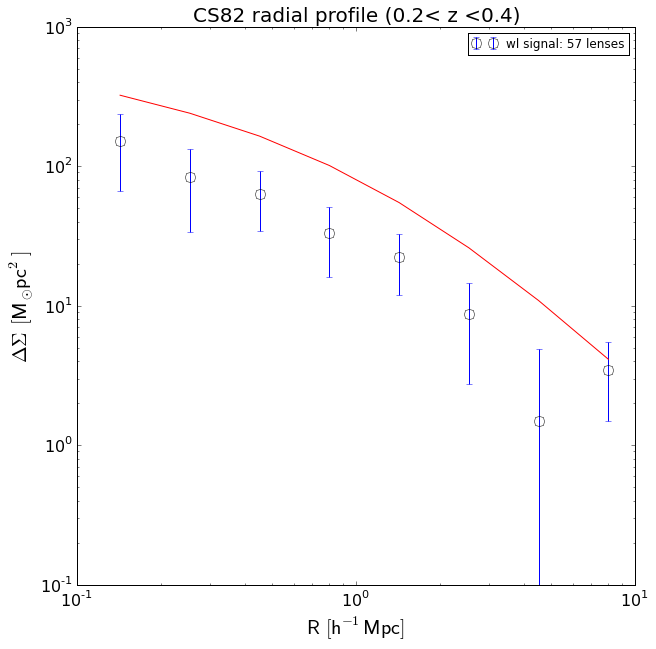

In [974]:
plot(R,DSobs,DSerr)
plt.plot(R, nfw_sd, 'r-', label='Prediction NFW')

## Writing the likelihoods 


Likelihood of $(r_s, \rho_s)$ given data $\Delta\Sigma_k^{obs}$:

${\rm Pr} (\Delta\Sigma_k^{obs}) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left[ - \frac{(\Delta\Sigma_k^{obs} - \Delta\Sigma_k)^2}{2\sigma^2_k} \right]$,

where $\Delta\Sigma_k$ is the predicted $k^{th}$ data point from the model, the NFW profile. Also is the "sampling distribution" to generate the data. For our example we are using a "simplified" NFW profile given by $\Delta\Sigma_{NFW} = \rho_s/(R/r_s)^2$.

But we want the likelihood of $(r_s, \rho_s)$ given **all** data, i.e., ${\rm Pr} (\{ \Delta\Sigma_k^{obs}\}|r_s,\rho_s)$. Then, **if the data points are independent**, we can do:

${\rm Pr} (\{ \Delta\Sigma_k^{obs}\}|r_s,\rho_s) = {\rm Pr} (\Delta\Sigma^{obs}_1, \Delta\Sigma^{obs}_2, ...| r_s,\rho_s) = {\rm Pr}(\Delta\Sigma^{obs}_1|r_s\rho_s){\rm Pr}(\Delta\Sigma^{obs}_2|r_s\rho_s)...$

then

${\rm Pr} ({\rm d}|r_s,\rho_s) = \prod_k {\rm Pr}(\Delta\Sigma_k^{obs}|r_s,\rho_s) $, where ${\rm d} = \{ \Delta\Sigma_k^{obs}\}$.

Taking the log likelihood

$\log {\rm Pr}({\rm d}| r_s,\rho_s) = \log \mathcal{L}  =  \sum_k \log {\rm Pr}(\Delta\Sigma_k|r_s\rho_s)$

$ \hspace{5cm}= \sum_k \left[ cte - 0.5 \frac{(\Delta\Sigma_k^{obs} - \Delta\Sigma_k)^2}{\sigma_k^2} \right],$ where $cte=-0.5 \log(2\pi\sigma^2)$.

We also want the "posterior PDF", ${\rm Pr} (r_s,\rho_s| {\rm d})$:

$ {\rm Pr} (r_s,\rho_s| {\rm d}) = \frac{{\rm Pr}({\rm d}|r_s,\rho_s) {\rm Pr}(r_s,\rho_s)}{{\rm Pr}({\rm d})}$



In [975]:
def log_likelihood(R, DSobs, DSerr, rs, ps):
    #return -0.5*np.sum(( DSobs - nfw_profile(R,rs,ps))**2/(DSerr**2))
    return -0.5*np.sum(( DSobs - np.array(map(nfw_profile_s, R/rs,np.ones(len(R))*ps)))**2/(DSerr**2))

def log_prior(rs,ps):
    rsmin, rsmax = 0.01, 10 #  
    psmin, psmax = 0.1, 200 # 
    
    if (rs<rsmin)|(rs>rsmax):
        log_rs_prior = -np.inf
    else:
        log_rs_prior = -np.log(rsmax-rsmin)
        
    if (ps<psmin)|(ps>psmax):
        log_ps_prior = -np.inf
    else:
        log_ps_prior = -np.log(psmax-psmin)
    return log_rs_prior+log_ps_prior
    
def log_posterior(R, DSobs, DSerr, rs, ps):
    return log_likelihood(R, DSobs, DSerr, rs, ps) + log_prior(rs, ps)

Set up a suitable parameter grid and compute the posterior PDF:

In [976]:
# Set up parameter grids:
npix = 101
rsmin,rsmax = 0.1, 10       #
psmin,psmax = 0.1, 200      #
rsgrid = np.linspace(rsmin,rsmax,npix)
psgrid = np.linspace(psmin,psmax,npix)
logprob = np.zeros([npix,npix])

# Loop over parameters, computing unormalized log posterior PDF:
for i,rs in enumerate(rsgrid):
    for j,ps in enumerate(psgrid):
        logprob[j,i] = log_posterior(R,DSobs,DSerr,rs,ps)
        
# Normalize and exponentiate to get posterior density:
Z = np.max(logprob)
prob = np.exp(logprob - Z)
norm = np.sum(prob)
prob /= norm        


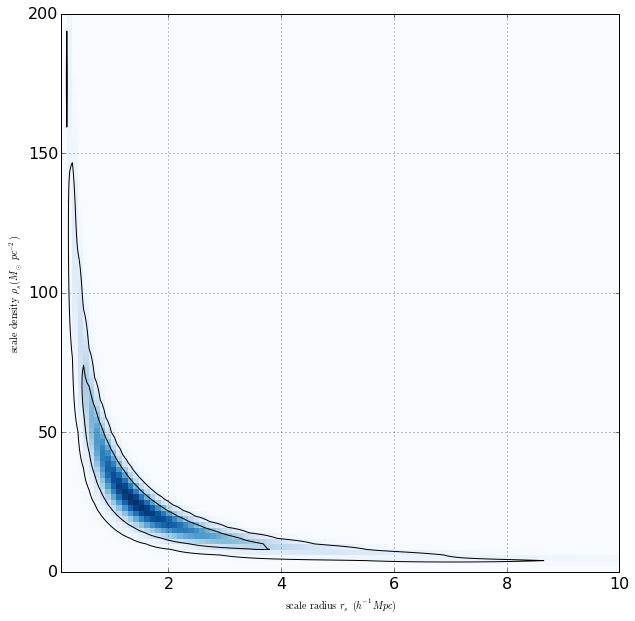

In [977]:
sorted = np.sort(prob.flatten())
C = sorted.cumsum()

# Find the pixel values that lie at the levels that contain
# 68% and 95% of the probability:
lvl68 = np.min(sorted[C > (1.0 - 0.68)])
lvl95 = np.min(sorted[C > (1.0 - 0.95)])

plt.figure
fig = plt.figure(figsize=(10, 10))
#ax  = fig.add_subplot(1,1,1,yscale='log',xscale='log')
plt.imshow(prob, origin='lower', cmap='Blues', interpolation='none', extent=[rsmin,rsmax,psmin,psmax], aspect='auto') #change to the prior range 
plt.contour(prob,[lvl68,lvl95],colors='black',extent=[rsmin,rsmax,psmin,psmax], aspect='auto')
plt.grid()
plt.xlabel(r'$ {\rm scale} \,{\rm radius} \, r_s\, (h^{-1} Mpc)$')
plt.ylabel(r'$ {\rm scale} \,{\rm density} \, \rho_s (M_\odot\,pc^{-2})$')
#plt.ylim(24, 24.4)
#plt.xlim(1,1.02)#(1, 1.01)
plt.show()

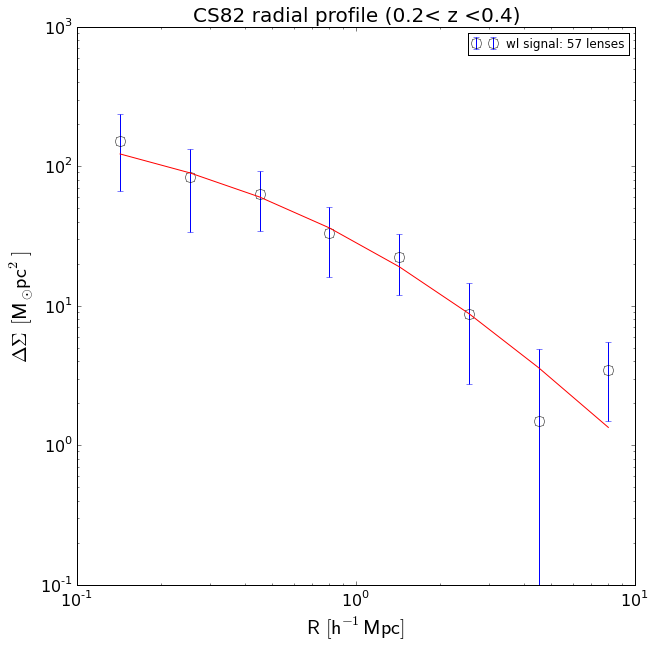

In [981]:
rs=1.33; ps=24.08
plot(R, DSobs, DSerr)
plt.plot(R, np.array(map(nfw_profile_s, R/rs,np.ones(len(R))*ps)), 'r-', label='Prediction NFW')

In [982]:
prob_rs_given_data = np.sum(prob,axis=0)
prob_ps_given_data = np.sum(prob,axis=1)

In [983]:
print(prob_rs_given_data.shape, np.sum(prob_ps_given_data))

(101,) 1.0


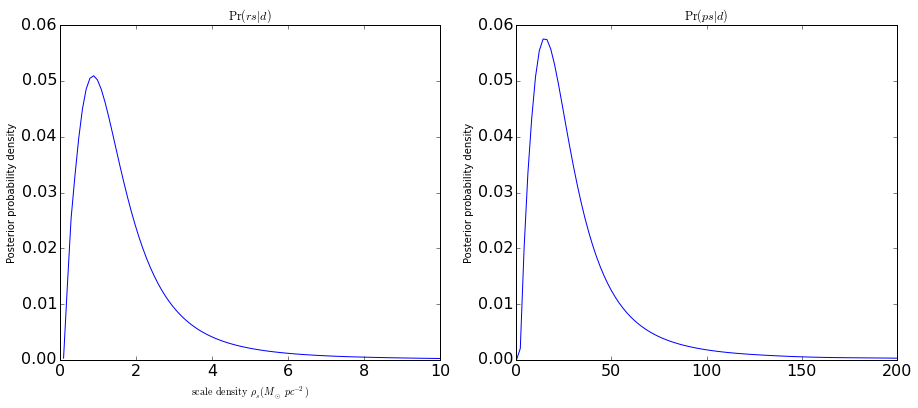

In [984]:
# Plot 1D distributions:

fig,ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)
plt.subplots_adjust(wspace=0.2)

left = ax[0].plot(rsgrid, prob_rs_given_data)
ax[0].set_title('${\\rm Pr}(rs|d)$')
ax[0].set_xlabel(r'$ {\rm scale} \,{\rm radius} \, r_s\, (h^{-1} Mpc)$')
ax[0].set_ylabel('Posterior probability density')

right = ax[1].plot(psgrid, prob_ps_given_data)
ax[1].set_title('${\\rm Pr}(ps|d)$')
ax[0].set_xlabel(r'$ {\rm scale} \,{\rm density} \, \rho_s (M_\odot\,pc^{-2})$')
ax[1].set_ylabel('Posterior probability density')

In [985]:
# Compress each PDF into a median and 68% credible interval, and report:

def compress_1D_pdf(x,pr,ci=68,dp=1):
    
    # Interpret credible interval request:
    low  = (1.0 - ci/100.0)/2.0    # 0.16 for ci=68
    high = 1.0 - low               # 0.84 for ci=68

    # Find cumulative distribution and compute percentiles:
    cumulant = pr.cumsum()
    pctlow = x[cumulant>low].min()
    median = x[cumulant>0.50].min()
    pcthigh = x[cumulant>high].min()
    
    # Convert to error bars, and format a string:
    errplus = np.abs(pcthigh - median)
    errminus = np.abs(median - pctlow)
    
    report = "$ "+str(round(median,dp))+"^{+"+str(round(errplus,dp))+"}_{-"+str(round(errminus,dp))+"} $"
    
    return report

In [986]:
print("rs = ",compress_1D_pdf(rsgrid,prob_rs_given_data,ci=68,dp=2))

print("ps = ",compress_1D_pdf(psgrid,prob_ps_given_data,ci=68,dp=2))

rs =  $ 1.39^{+1.39}_{-0.69} $
ps =  $ 24.09^{+25.99}_{-11.99} $
